# CSC 522 Project 
_by Team 21: Raphael Phillips (rjphill4), Sogolsadat Mansouri (smansou2), Rithik Jain (rjain25), and Neeloy Gomes (ntgomes)_

This project will involve developing a machine learning model using supervised learning to predict future exchange rates for a specific currency pair, based on historical exchange rate data and other relevant features.


In [33]:
%run data_cleaner.py

uscinrx_df = pd.read_csv('../data/USDINRX.csv')
cleaned_uscinrx_df = remove_rows_with_null_values(uscinrx_df)
print('Cleaned ' + str(len(uscinrx_df.index) - len(cleaned_uscinrx_df.index)) + ' rows from data/USDINRX.csv')

forex_df = pd.read_csv('../data/forex.csv')
cleaned_forex_df = remove_rows_with_null_values(forex_df)
print('Cleaned ' + str(len(forex_df.index) - len(cleaned_forex_df.index)) + ' rows from data/forex.csv')

Cleaned 52 rows from data/USDINRX.csv
Cleaned 0 rows from data/forex.csv


(1453035, 7)

EUR
GBP
USD
JPY
CHF
AUD
INR


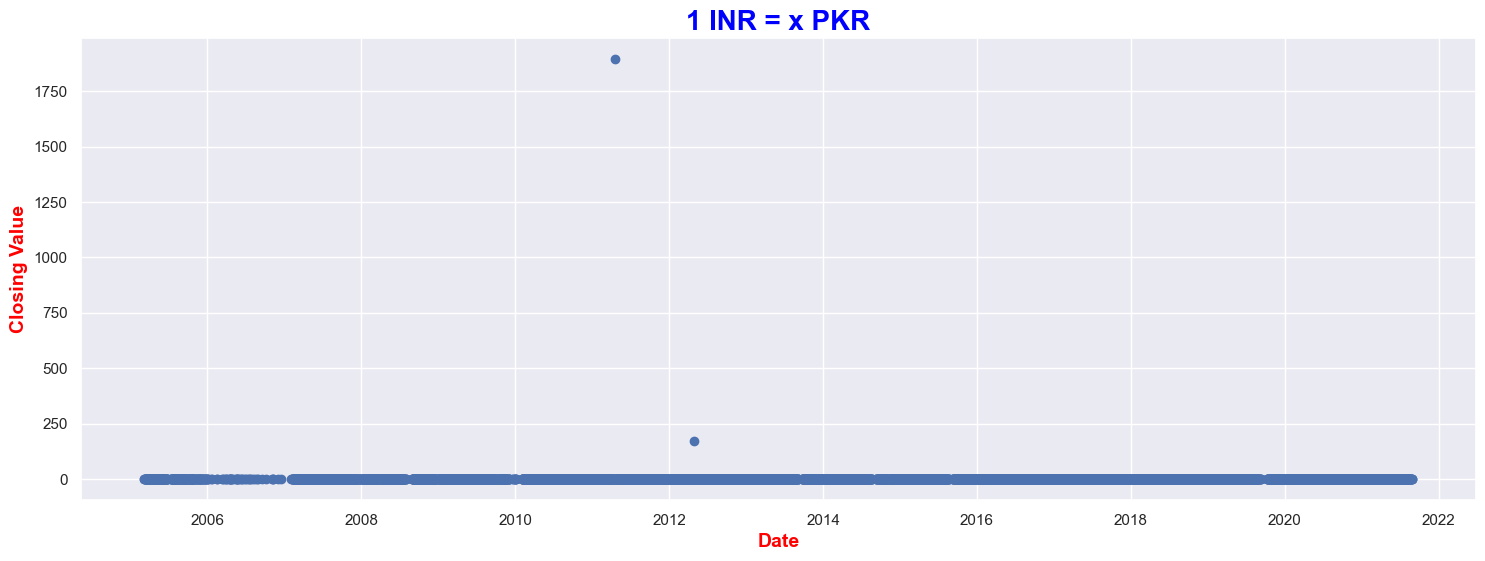

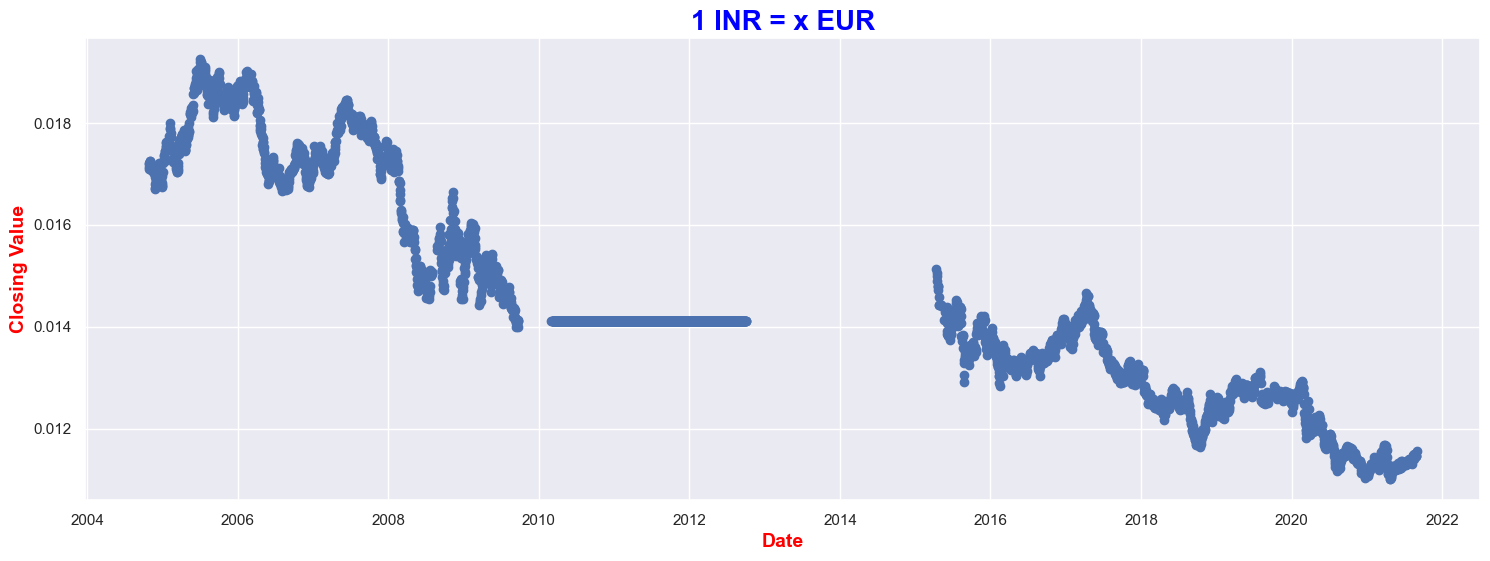

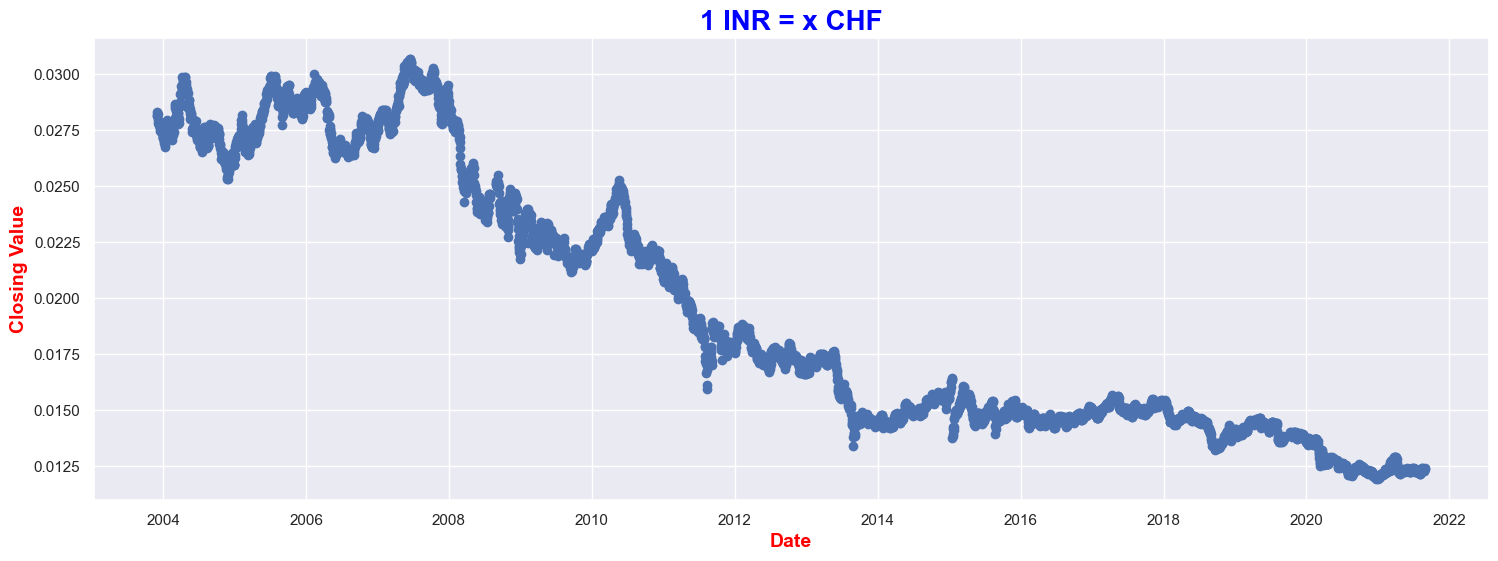

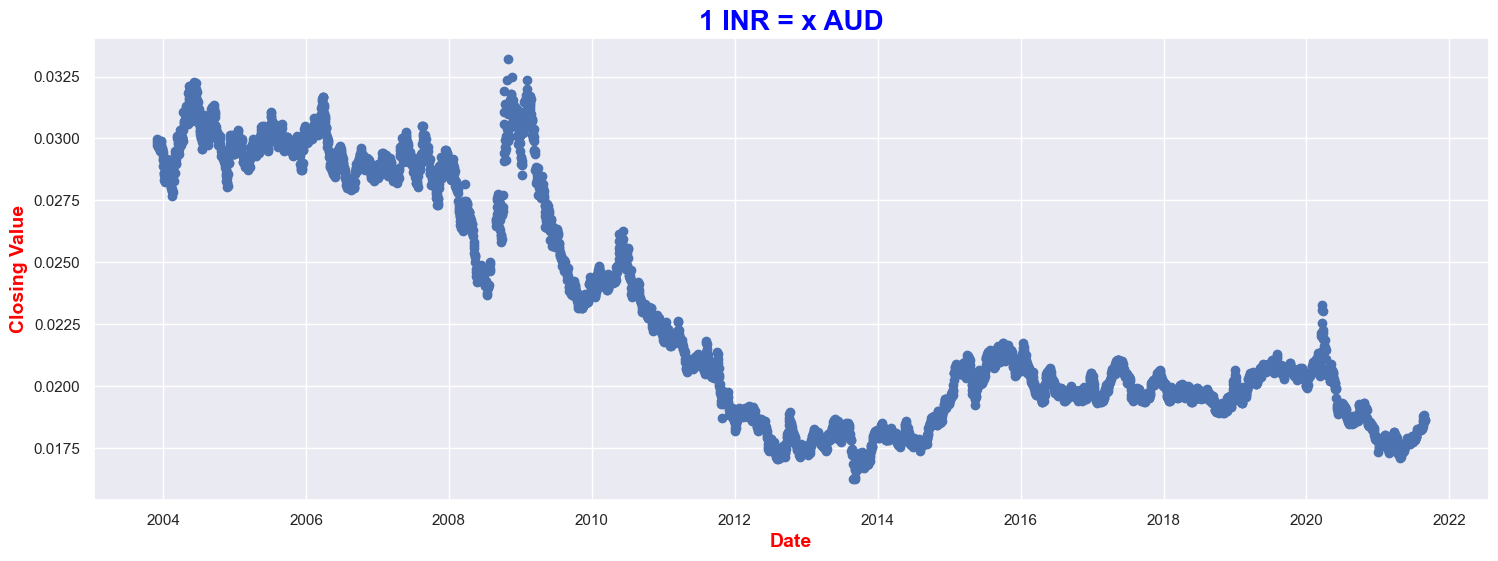

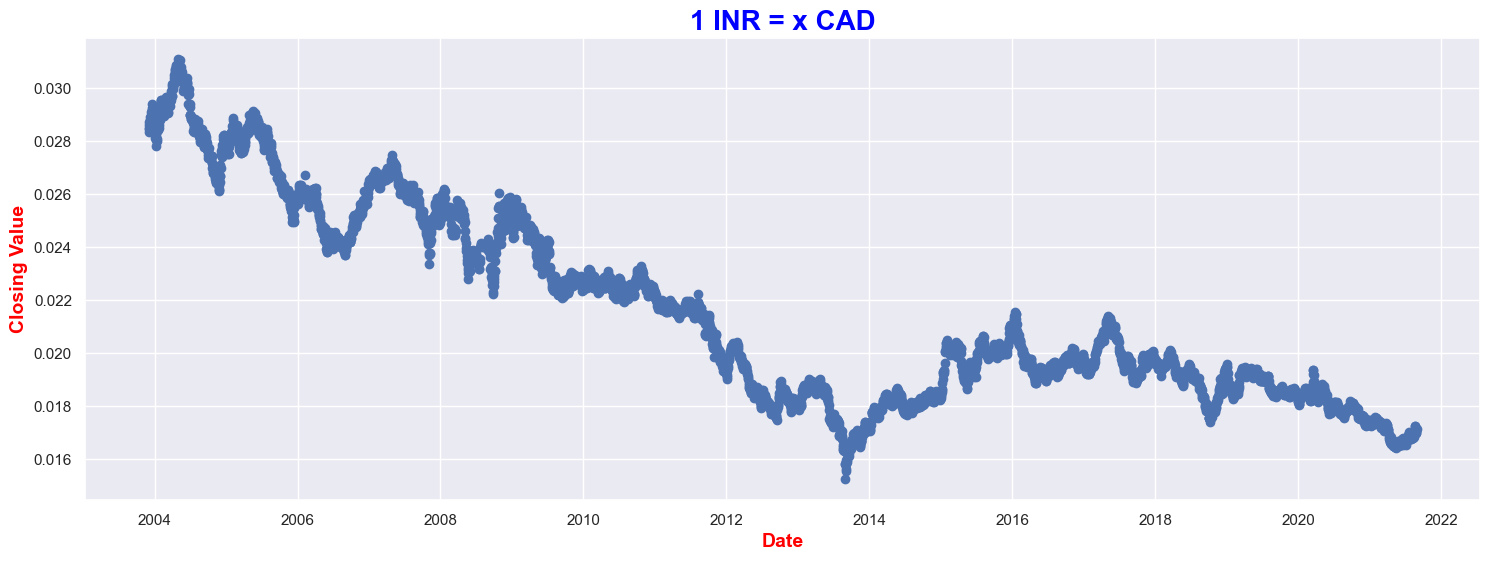

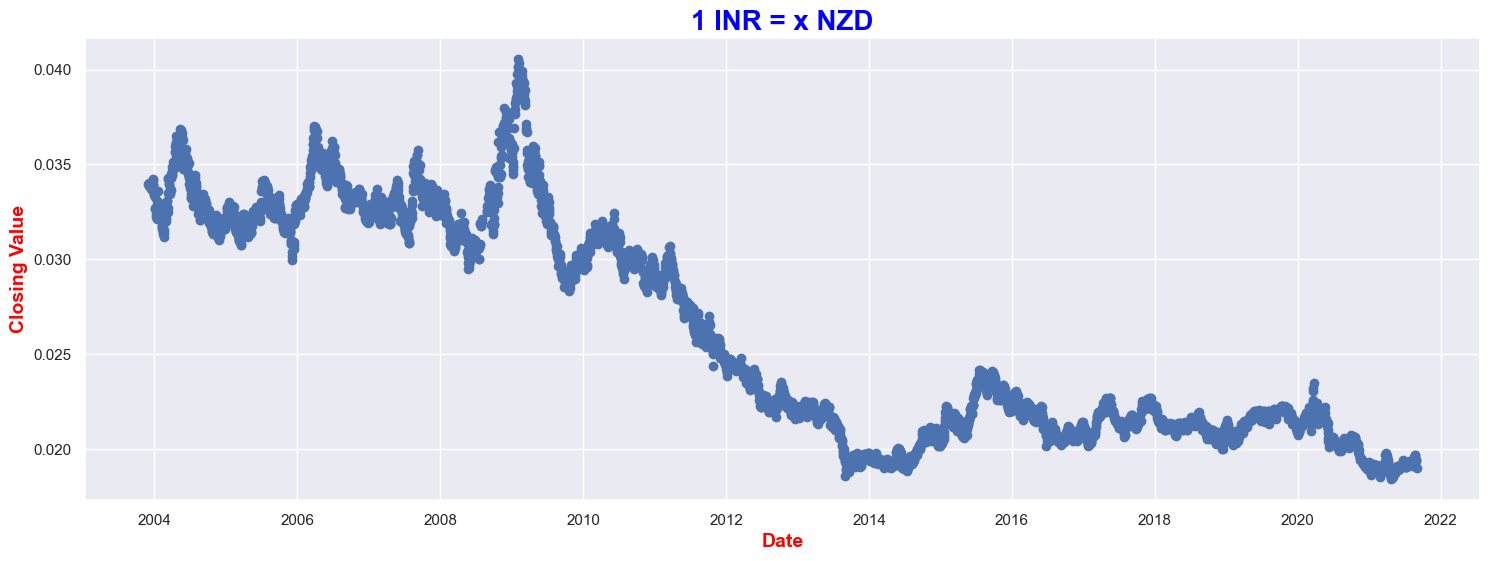

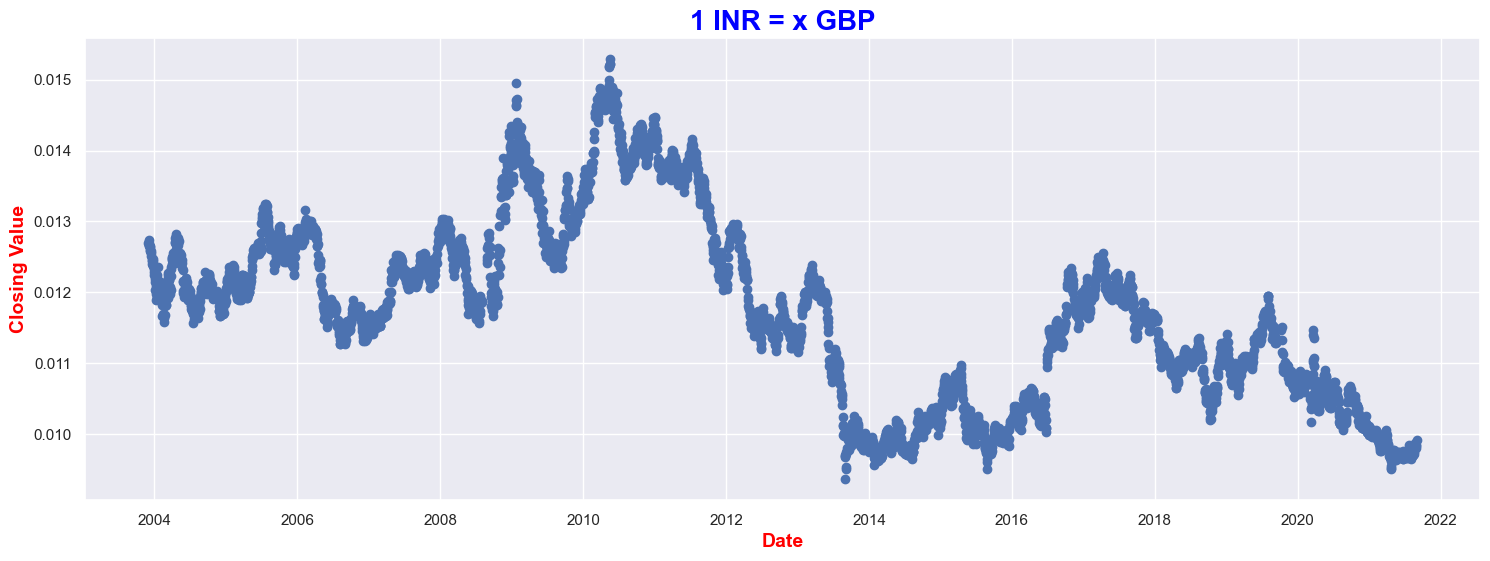

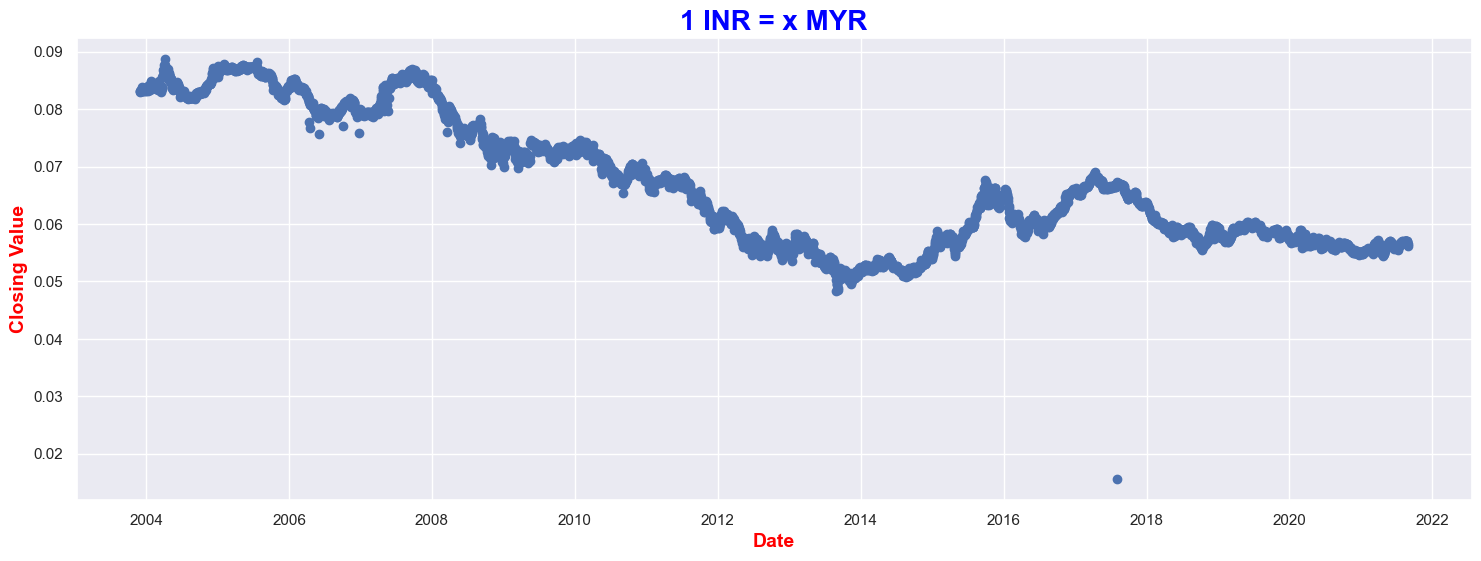

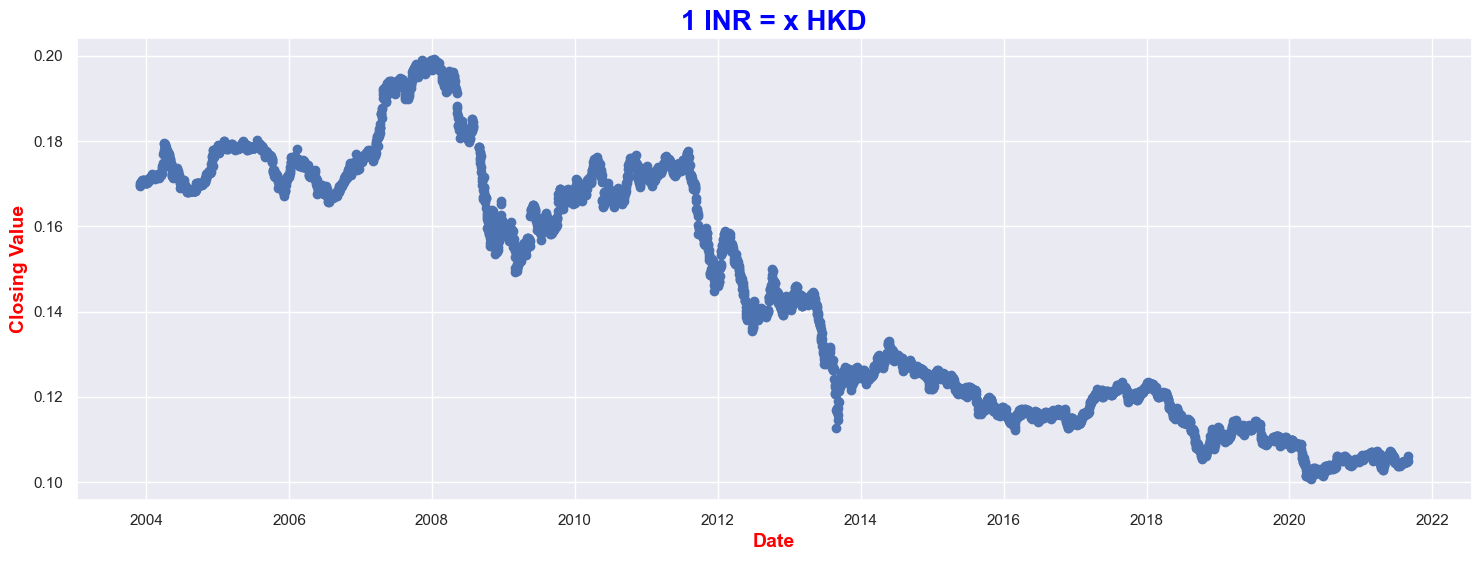

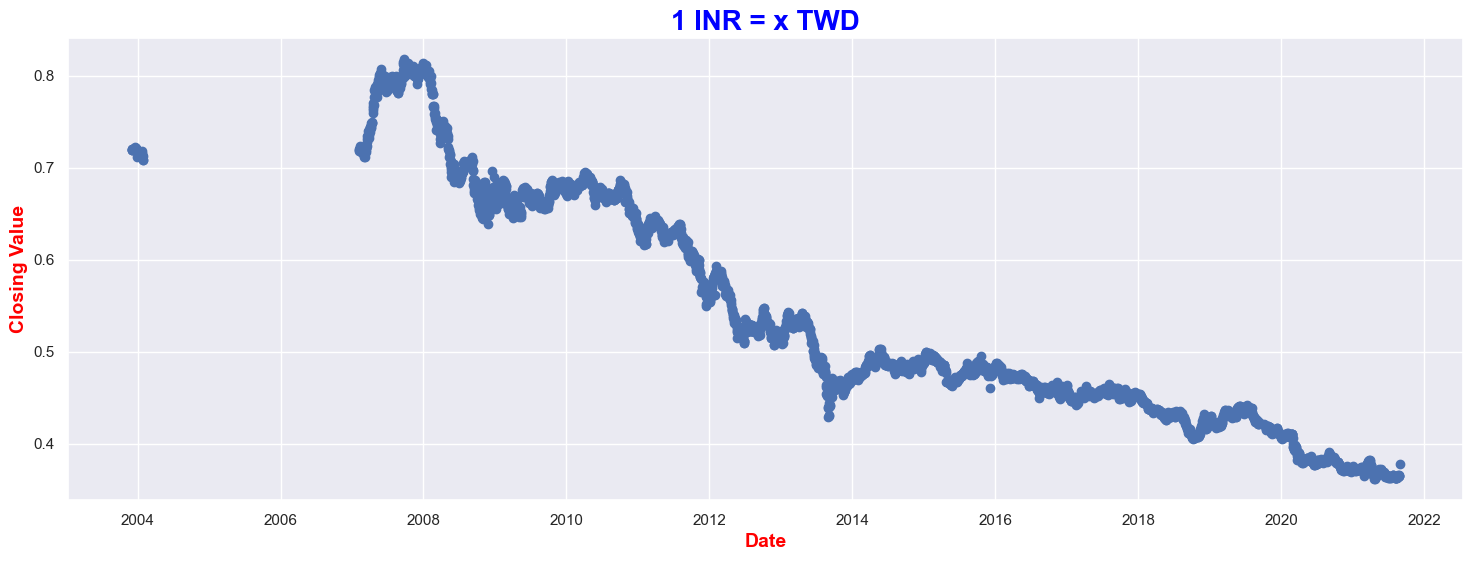

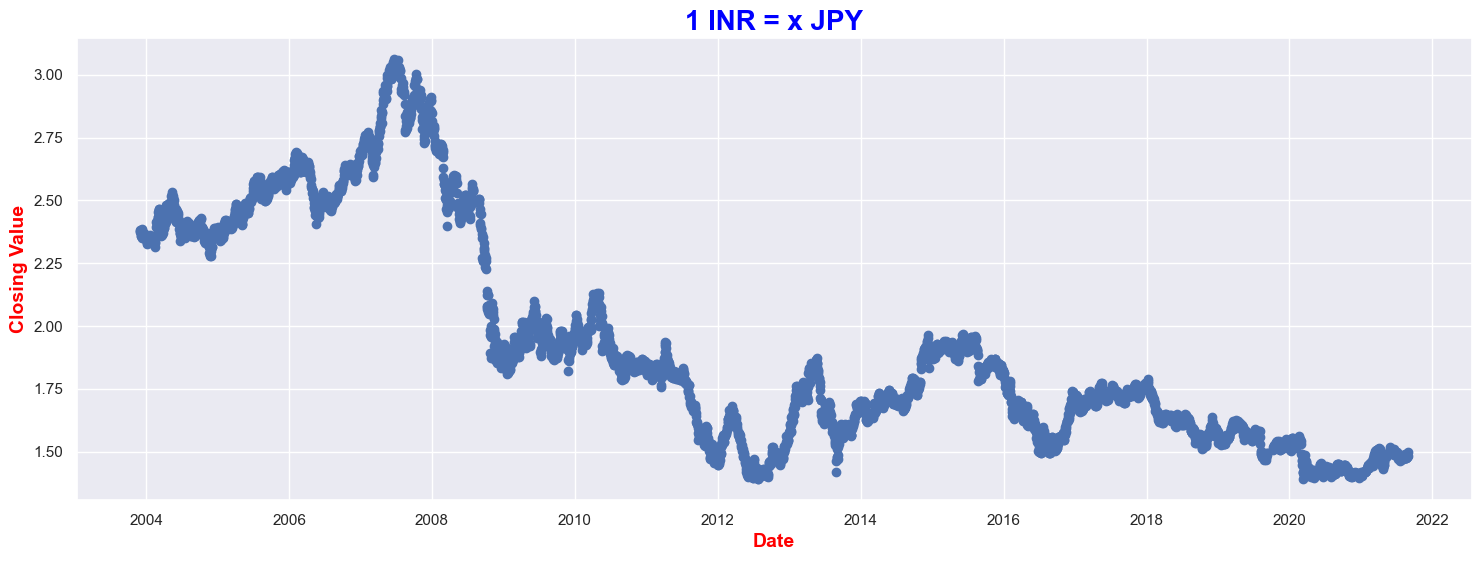

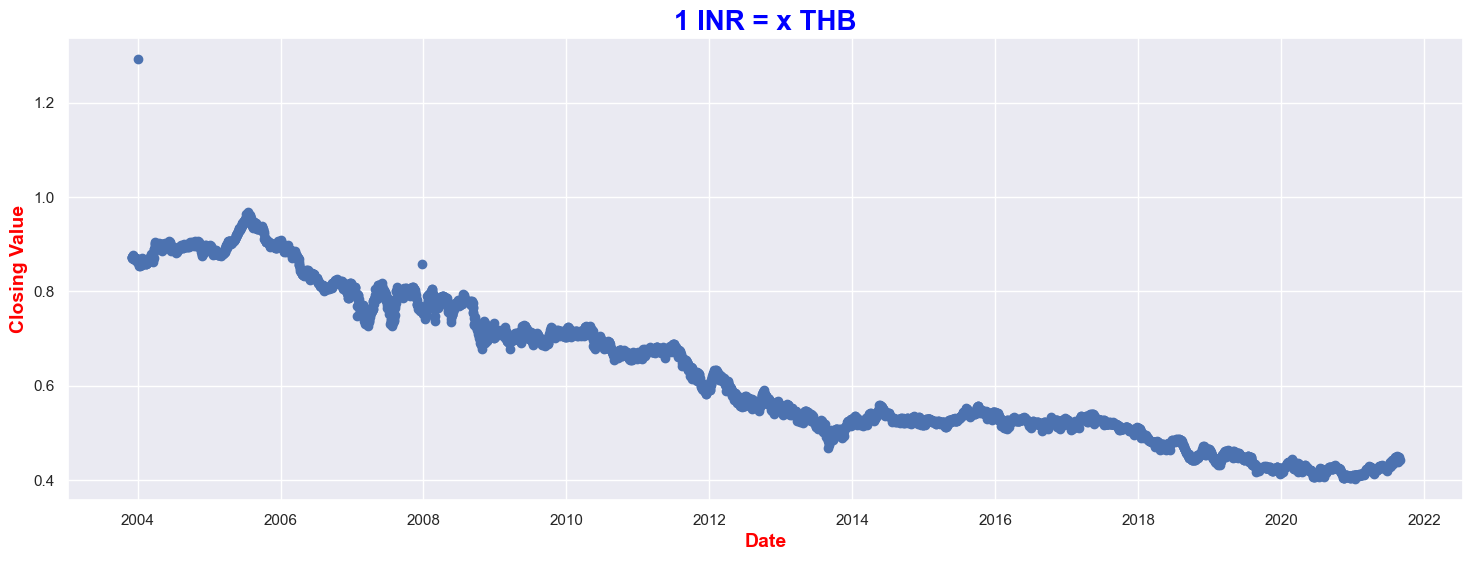

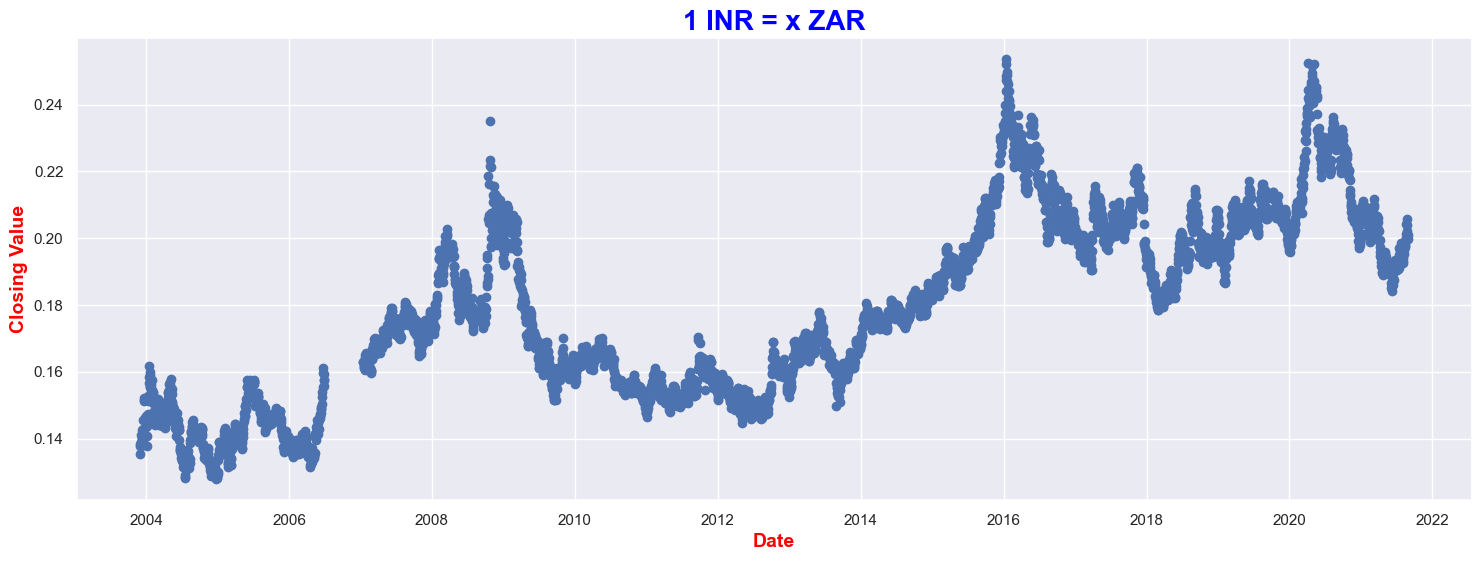

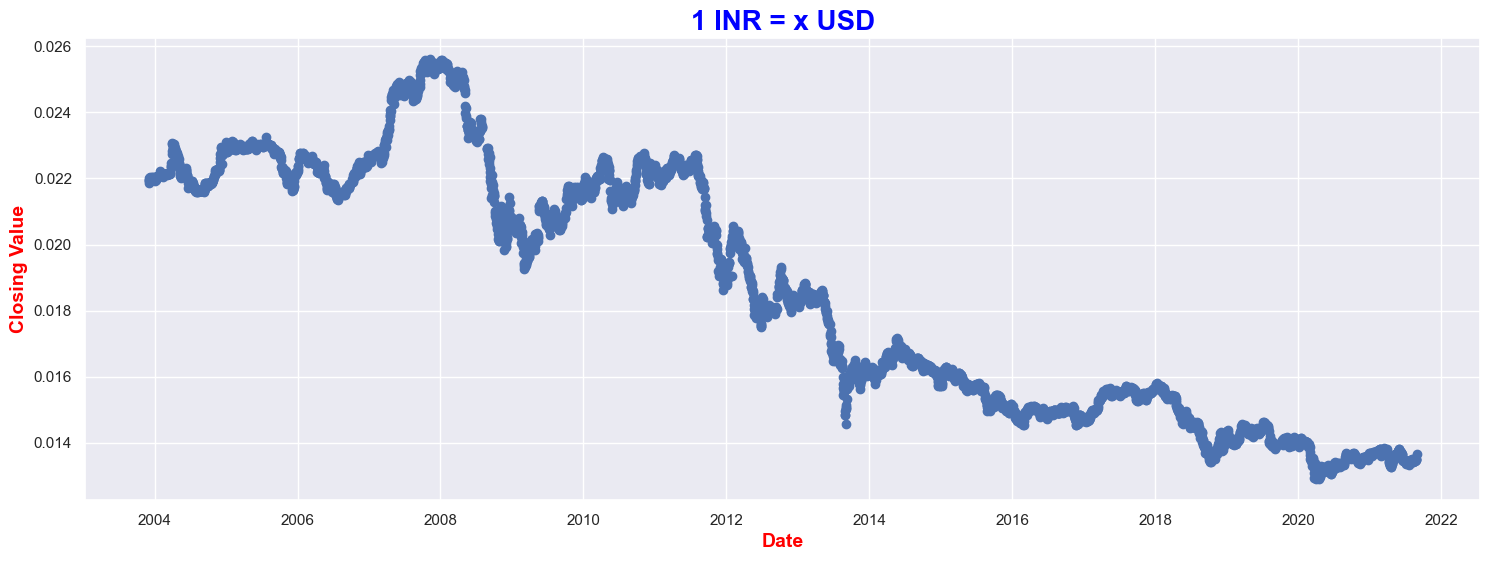

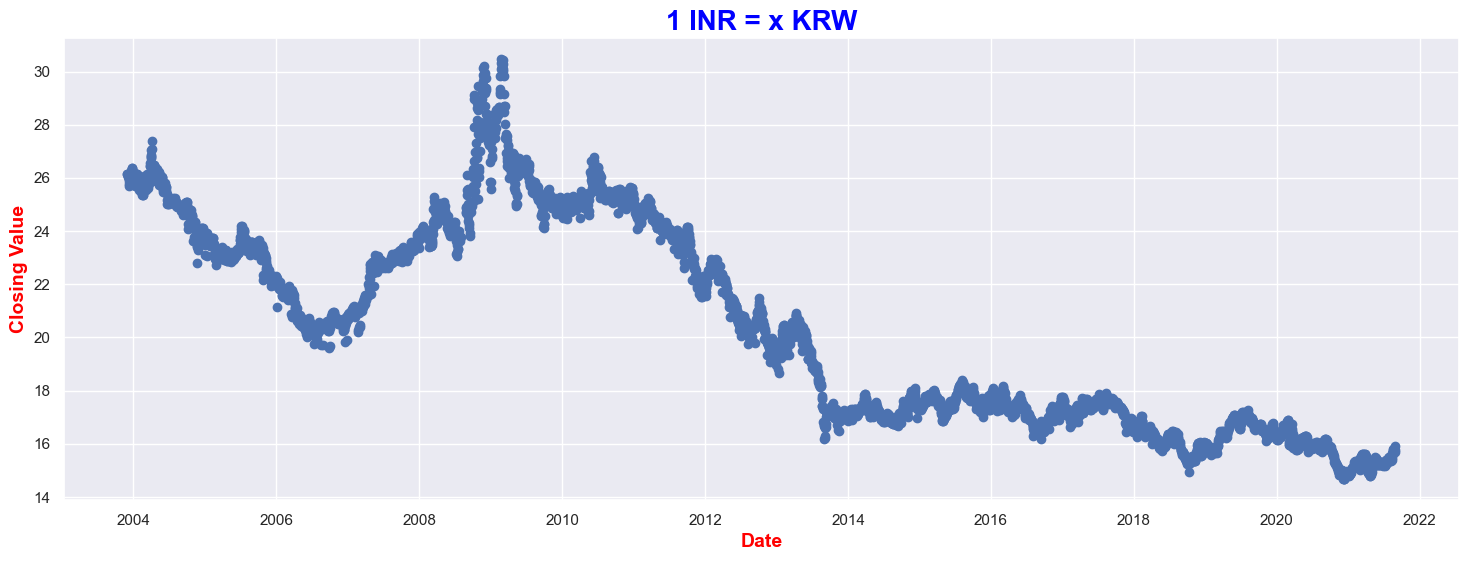

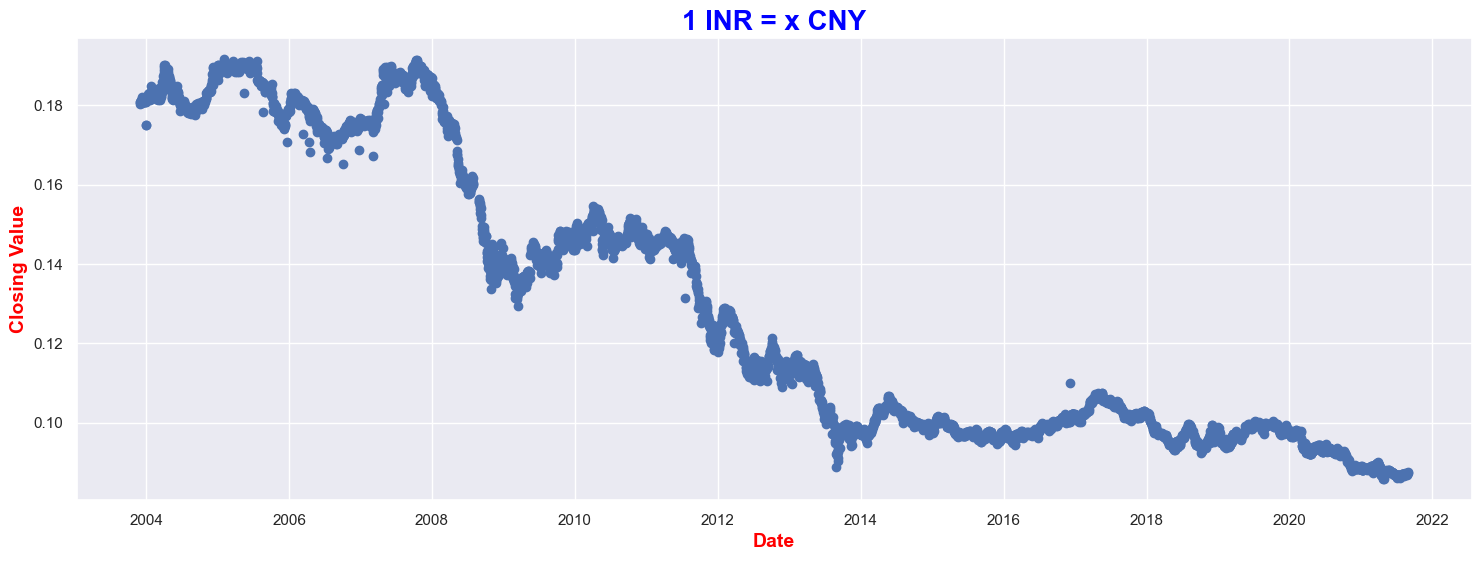

In [34]:
%run exploratory_analysis.py

do_analysis()